In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid
from models import MRIResNetClassifier, MRI_VGG16_Classifier
from multiprocessing import cpu_count

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_data_full = datasets.ImageFolder(root="cleaned/Training", transform=transform)
class_names = train_data_full.classes

train_size = int(0.8 * len(train_data_full))  # 80% za trening
val_size = len(train_data_full) - train_size  # 20% za validaciju

train_data, val_data = random_split(train_data_full, [train_size, val_size])
test_data = datasets.ImageFolder(root="cleaned/Testing", transform=transform)

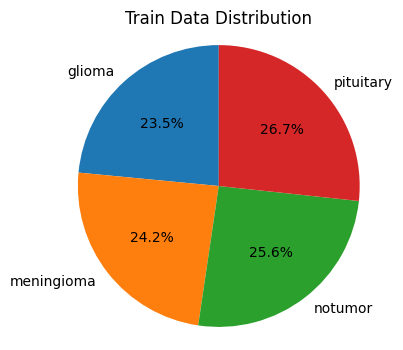

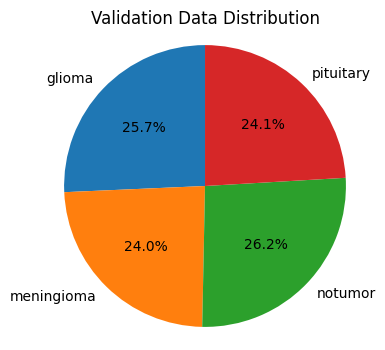

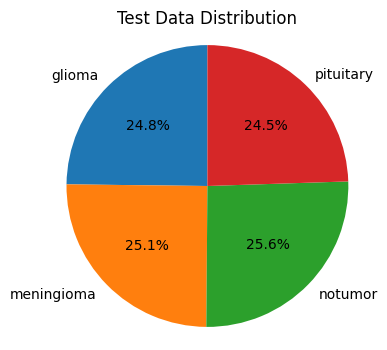

In [4]:
def plot_class_distribution(data, title):
    counts = Counter(data.targets if hasattr(data, 'targets') else [x[1] for x in data])
    labels = [class_names[i] for i in range(len(class_names))]
    plt.figure(figsize=(4, 4))
    plt.pie([counts[i] for i in range(len(class_names))], labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.axis('equal')
    plt.show()

plot_class_distribution(train_data, "Train Data Distribution")
plot_class_distribution(val_data, "Validation Data Distribution")
plot_class_distribution(test_data, "Test Data Distribution")

In [5]:
train_targets = [train_data_full[i][1] for i in train_data.indices]
val_targets = [train_data_full[i][1] for i in val_data.indices]
test_targets = [label for _, label in test_data] 

def count_classes(targets, num_classes):
    counts = [0] * num_classes
    for target in targets:
        counts[target] += 1
    return counts

train_counts = count_classes(train_targets, len(class_names))
val_counts = count_classes(val_targets, len(class_names))
test_counts = count_classes(test_targets, len(class_names))


print("Train-Val-Test Split per Class:")
for i, class_name in enumerate(class_names):
    train_count = train_counts[i]
    val_count = val_counts[i]
    test_count = test_counts[i]
    total_count = train_count + val_count + test_count
    
    train_percentage = (train_count / total_count) * 100 if total_count > 0 else 0
    val_percentage = (val_count / total_count) * 100 if total_count > 0 else 0
    test_percentage = (test_count / total_count) * 100 if total_count > 0 else 0
    
    print(f"{class_name}: Train = {train_count} ({train_percentage:.2f}%), "
          f"Val = {val_count} ({val_percentage:.2f}%), "
          f"Test = {test_count} ({test_percentage:.2f}%)")

Train-Val-Test Split per Class:
glioma: Train = 1037 (64.01%), Val = 284 (17.53%), Test = 299 (18.46%)
meningioma: Train = 1068 (65.32%), Val = 265 (16.21%), Test = 302 (18.47%)
notumor: Train = 1132 (65.40%), Val = 290 (16.75%), Test = 309 (17.85%)
pituitary: Train = 1179 (67.76%), Val = 266 (15.29%), Test = 295 (16.95%)


In [6]:
num_workers = cpu_count() // 2

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=num_workers)

In [7]:
def train(model, epochs, train_loader, val_loader, optimizer, criterion, device):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        train_pred_correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            train_pred_correct += (outputs.argmax(1) == labels).sum().item()
            total += len(labels)

        train_accuracy = train_pred_correct / total

        model.eval()
        total_val_loss = 0.0
        val_pred_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                val_pred_correct += (outputs.argmax(1) == labels).sum().item()
                total_val += len(labels)

        val_accuracy = val_pred_correct / total_val

        print(f"Epoch {epoch+1}: Train Loss={total_train_loss/len(train_loader):.4f}, "
              f"Train Acc={train_accuracy:.4f}, Val Loss={total_val_loss/len(val_loader):.4f}, "
              f"Val Acc={val_accuracy:.4f}")


def evaluate(model, loader, criterion, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred_labels = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred_labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="macro")

    print("Confusion matrix:\n", conf_matrix)
    print('Accuracy:', acc)
    print('F1 score:', f1)
    return acc, f1
                

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

best_params = None
best_accuracy = 0.0

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = MRIResNetClassifier(len(train_data_full.classes)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train(model, params['epochs'], train_loader, val_loader, optimizer, criterion, device)
    acc, _ = evaluate(model, val_loader, criterion, device)

    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params

print("Best Hyperparameters:", best_params)

In [ ]:
model = MRIResNetClassifier(len(train_data_full.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()
train(model, best_params['epochs'], train_loader, val_loader, optimizer, criterion, device)

print('Test evaluation:')
evaluate(model, test_loader, criterion, device)

In [9]:
param_grid = {
    'lr': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [5, 10]
}

best_params = None
best_accuracy = 0.0

for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = MRI_VGG16_Classifier(len(train_data_full.classes)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    train(model, params['epochs'], train_loader, val_loader, optimizer, criterion, device)
    acc, _ = evaluate(model, val_loader, criterion, device)

    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params

print("Best Hyperparameters:", best_params)

Testing parameters: {'batch_size': 16, 'epochs': 5, 'lr': 0.01}


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/ante/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [02:00<00:00, 4.60MB/s] 


Epoch 1: Train Loss=1.0904, Train Acc=0.6486, Val Loss=1.0422, Val Acc=0.6968
Epoch 2: Train Loss=1.0322, Train Acc=0.7086, Val Loss=0.9619, Val Acc=0.7756
Epoch 3: Train Loss=0.9790, Train Acc=0.7629, Val Loss=0.9487, Val Acc=0.8063
Epoch 4: Train Loss=0.9691, Train Acc=0.7738, Val Loss=0.9371, Val Acc=0.8154
Epoch 5: Train Loss=0.9704, Train Acc=0.7706, Val Loss=0.9044, Val Acc=0.8416
Confusion matrix:
 [[224  36   6  18]
 [ 21 172  20  52]
 [  2   5 279   4]
 [  4   7   0 255]]
Accuracy: 0.8416289592760181
F1 score: 0.8354048778197086
Testing parameters: {'batch_size': 16, 'epochs': 5, 'lr': 0.001}
Epoch 1: Train Loss=0.9911, Train Acc=0.7679, Val Loss=0.9058, Val Acc=0.8579
Epoch 2: Train Loss=0.9281, Train Acc=0.8202, Val Loss=0.8876, Val Acc=0.8661
Epoch 3: Train Loss=0.9120, Train Acc=0.8367, Val Loss=0.8811, Val Acc=0.8751
Epoch 4: Train Loss=0.9063, Train Acc=0.8410, Val Loss=0.8841, Val Acc=0.8624
Epoch 5: Train Loss=0.9042, Train Acc=0.8410, Val Loss=0.8687, Val Acc=0.8878
C

In [10]:
model = MRI_VGG16_Classifier(len(train_data_full.classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
criterion = torch.nn.CrossEntropyLoss()
train(model, best_params['epochs'], train_loader, val_loader, optimizer, criterion, device)

print('Test evaluation:')
evaluate(model, test_loader, criterion, device)

Epoch 1: Train Loss=1.0117, Train Acc=0.7509, Val Loss=0.9245, Val Acc=0.8380
Epoch 2: Train Loss=0.9334, Train Acc=0.8182, Val Loss=0.8945, Val Acc=0.8606
Epoch 3: Train Loss=0.9205, Train Acc=0.8252, Val Loss=0.8848, Val Acc=0.8715
Epoch 4: Train Loss=0.9116, Train Acc=0.8379, Val Loss=0.8784, Val Acc=0.8733
Epoch 5: Train Loss=0.9039, Train Acc=0.8440, Val Loss=0.8949, Val Acc=0.8489
Epoch 6: Train Loss=0.8953, Train Acc=0.8535, Val Loss=0.8675, Val Acc=0.8869
Epoch 7: Train Loss=0.8992, Train Acc=0.8478, Val Loss=0.8614, Val Acc=0.8878
Epoch 8: Train Loss=0.8910, Train Acc=0.8576, Val Loss=0.8815, Val Acc=0.8670
Epoch 9: Train Loss=0.8894, Train Acc=0.8594, Val Loss=0.8808, Val Acc=0.8633
Epoch 10: Train Loss=0.8882, Train Acc=0.8553, Val Loss=0.8646, Val Acc=0.8796
Test evaluation:
Confusion matrix:
 [[230  50   0  19]
 [ 31 179  38  54]
 [  1   2 306   0]
 [  7   5   0 283]]
Accuracy: 0.8282157676348548
F1 score: 0.8204827928886056


(0.8282157676348548, 0.8204827928886056)